<a href="https://colab.research.google.com/github/GalaIvannikova/Alcohol-Consumption-in-Russia-1998-2016-_eng/blob/main/Alcohol_Consumption_in_Russia_(1998_2016)_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alcohol Consumption in Russia (1998-2016)

In [30]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
import geopandas as gpd

**Context**

This is Alcohol Consumption in Russia (1998-2016) Dataset. It contains values of consumption for wine, beer, vodka, brandy and champagne.

**Content**

Dataset has 1615 rows and 7 columns. Keys for columns:

* "year" - year (1998-2016)
* "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
* "wine" - sale of wine in litres by year per capita
* "beer" - sale of beer in litres by year per capita
* "vodka" - sale of vodka in litres by year per capita
* "champagne" - sale of champagne in litres by year per capita
* "brandy" - sale of brandy in litres by year per capita

# Load and overview dataset

In [32]:
#Load dataset from the file
#Link to the document - https://www.dropbox.com/s/mwu378e3674ruh6/russia_alcohol.csv?dl=0
df = pd.read_csv('russia_alcohol.csv')

In [33]:
#Show the first 5 rows
df.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


In [34]:
#Let's see dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


Columns types:
* "year" - integer
* "region" - object
* "wine", "beer", "vodka", "champagne", "brandy" - float

The number of Non-Null rows is different for different columns. And we can conclude that current dataset contents empty cells.

# Missing data search

Let's find missing data and make a decision about work with them.

In [35]:
# Let's group data by years
df.groupby('year').count()

# In total, we have data for 19 years from 1998 to 2016

,region,wine,beer,vodka,champagne,brandy
year,,,,,,
1998,85,81,81,81,81,81
1999,85,81,81,81,81,81
2000,85,81,81,81,81,81
2001,85,82,82,82,82,82
2002,85,82,82,82,82,82
2003,85,82,82,82,82,82
2004,85,82,82,82,82,82
2005,85,82,82,82,82,81
2006,85,82,82,82,82,81


Columns with types of drinks are missing data for exactly the same years.

Idea: missing data from particular regions. If it is true, we can exclude those regions from the analysis or assign them an average from the country.

In [36]:
#Let's group data by region.
#We are interested in regions with a number of rows less than 19.
df_null_region = df.groupby('region').count()
df_null_region[(df_null_region['wine'] < 19) | (df_null_region['beer'] < 19) | (df_null_region['vodka'] < 19) | (df_null_region['champagne'] < 19) | (df_null_region['brandy'] < 19)]

,year,wine,beer,vodka,champagne,brandy
region,,,,,,
Chechen Republic,19,0,3,0,0,0
Republic of Crimea,19,3,3,3,3,3
Republic of Ingushetia,19,7,9,9,7,4
Sevastopol,19,3,3,3,3,3


Data missing in 4 regions. In the Republic of Ingushetia data is missing from half of all years. For other regions data is missing from 3-4 years.

We will exclude the Republic of Ingushetia data from the feather analysis. If needed it is possible to take a look at this data separately.

For other regions let's change missing data to the average.

# Key statistic metrics and average

In [37]:
# Let's see standard statistics for our dataset
df.describe()

,year,wine,beer,vodka,champagne,brandy
count,1615.000000,1552.000000,1557.000000,1554.000000,1552.000000,1549.000000
mean,2007.000000,5.628144,51.260148,11.818694,1.313177,0.526998
std,5.478922,2.813208,25.372821,5.128806,0.797956,0.400201
min,1998.000000,0.100000,0.400000,0.050000,0.100000,0.000000
25%,2002.000000,3.575000,32.400000,8.300000,0.800000,0.200000
50%,2007.000000,5.400000,49.970000,11.500000,1.200000,0.400000
75%,2012.000000,7.377500,67.400000,15.000000,1.665000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


Since the mean do not different much from the second percentile (50%), I suppose fill the 'Null' with mean for current region based on the other years.

In [38]:
# Let's remove data for the Republic of Ingushetia from the dataset as we decided earlier.

df_filter = df[df['region'] != 'Republic of Ingushetia']
df_filter.head(10)

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2
5,1998,Republic of Bashkortostan,1.8,17.5,10.7,0.9,0.2
6,1998,Belgorod Oblast,3.4,23.0,10.8,0.9,0.1
7,1998,Bryansk Oblast,3.4,32.4,9.7,0.5,0.1
8,1998,Republic of Buryatia,1.1,8.8,15.8,0.9,0.1
9,1998,Vladimir Oblast,1.5,16.6,16.8,0.5,0.1


In [39]:
# Let's find mean for each year and each drink.
df_mean = df_filter.groupby('year').mean().reset_index()
df_mean.head(20)

,year,wine,beer,vodka,champagne,brandy
0,1998,3.029630,20.419753,12.669136,0.913580,0.228889
1,1999,3.120988,25.395062,13.469136,0.846914,0.210864
2,2000,3.343210,30.130864,13.572840,0.892593,0.233704
3,2001,3.864198,36.675309,14.365432,0.927160,0.260494
4,2002,4.364198,42.791358,14.917284,0.969136,0.314815
5,2003,5.174074,47.849383,14.640741,1.038272,0.361728
6,2004,5.760494,53.045679,14.466667,1.097531,0.387654
7,2005,6.041975,55.160494,13.833333,1.185185,0.411111
8,2006,5.856790,62.285185,13.235802,1.230864,0.437037
9,2007,6.703704,62.764198,12.479012,1.422222,0.534568


We got mean data for each type of drinks by years. To understand this data better let's take a look at the chart.

# Average consumption per capita for Russia by years and drink type

In [40]:
# I create numpy array for X axis with list of the years
np_years = np.array(df_mean['year'])
np_years

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [41]:
# Create numpy array for Y axis with drink consumption data
np_wine_mean = np.array(df_mean['wine'])
np_beer_mean = np.array(df_mean['beer'])
np_vodka_mean = np.array(df_mean['vodka'])
np_champagne_mean = np.array(df_mean['champagne'])
np_brandy_mean = np.array(df_mean['brandy'])

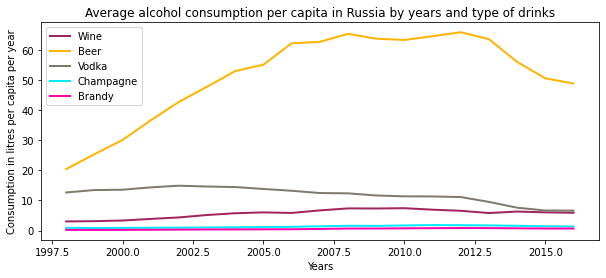

In [42]:
# Use list of the years as X axis and drinks consumption mean data as Y axis
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_wine_mean, '#a0265d', linewidth=2, label='Wine')
ax.plot(np_years, np_beer_mean, '#ffb400', linewidth=2, label='Beer')
ax.plot(np_years, np_vodka_mean, '#7f7a6d', linewidth=2, label='Vodka')
ax.plot(np_years, np_champagne_mean, '#00eaff', linewidth=2, label='Champagne')
ax.plot(np_years, np_brandy_mean, '#ff00a8', linewidth=2, label='Brandy')

ax.set_title('Average alcohol consumption per capita in Russia by years and type of drinks')
ax.set_xlabel('Years')
ax.set_ylabel('Consumption in litres per capita per year')
ax.legend()
 
plt.show()

On the chart above we can see the whole picture but is difficult to find trends for each type of drink. Let's see each type of drink separate.

## **Wine consumption in Russia by years**

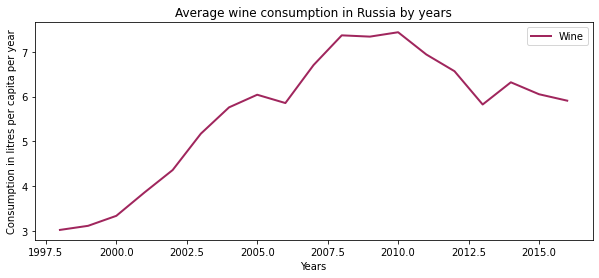

In [43]:
# Let's keep in the chart only data for wine.
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_wine_mean, '#a0265d', linewidth=2, label='Wine')

ax.set_title('Average wine consumption in Russia by years')
ax.set_xlabel('Years')
ax.set_ylabel('Consumption in litres per capita per year')
ax.legend()
 
plt.show()

The lowest wine consumption was in the beguinning of the analysis period - 3,03 letres per capita per year. 

Year by year this amount increased till 2010 when wine consuption was 7,43 letres.

Later consumption went down but not to low as in the beguining of the period and was near the mean data from the whole period - 5,6 letres per capita.

Let's use Mann–Whitney U-test and confirm that wine consumption in the first years (1998-2006) are different from the second period (2007-2016).

In [44]:
data1 = np_wine_mean[:9]
data2 = np_wine_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p)

Mann-Whitney U = 3.0
p-value = 0.0003514303595517608


p-value < 0.05 means that wine consumption in the first and the second period is different and this difference confirmed statistically.

## **Beer consumption in Russia by years**

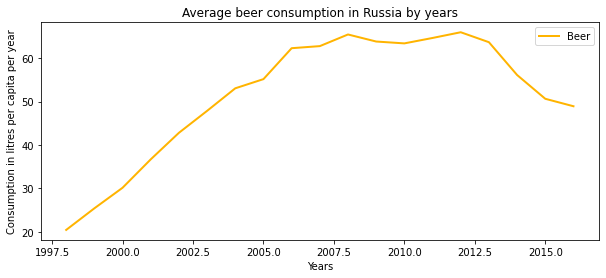

In [45]:
# Let's keep in the chart only data for beer
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_beer_mean, '#ffb400', linewidth=2, label='Beer')

ax.set_title('Average beer consumption in Russia by years')
ax.set_xlabel('Years')
ax.set_ylabel('Consumption in litres per capita per year')
ax.legend()
 
plt.show()

Beer consumption in Russia increased several times during the reporting period from 20,4 litres in 1998 to 66 litres in 2012 per capita per year.

From 2012 to 2016 amount decreasing smootly to 49 litres.

**Hypothesis**

In the first half of the reporting period beer consumption is different from the second part.

Let's proof it with Mann–Whitney U-test.

In [46]:
data1 = np_beer_mean[:9]
data2 = np_beer_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 7.0
p-value = 0.001099823530556528


Since the p-value is much less than 0.05 it can be concluded that the difference between samples is statistically significant.

##**Vodka consumption in Russia by years**

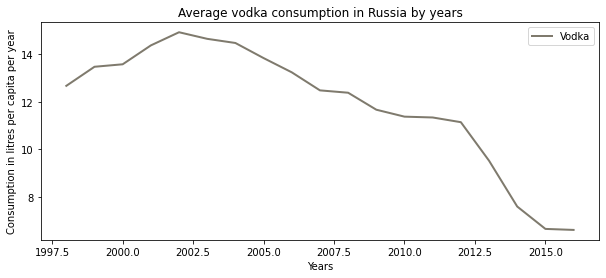

In [47]:
# Let's keep in the chart only data for vodka
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_vodka_mean, '#7f7a6d', linewidth=2, label='Vodka')

ax.set_title('Average vodka consumption in Russia by years')
ax.set_xlabel('Years')
ax.set_ylabel('Consumption in litres per capita per year')
ax.legend()
 
plt.show()

As you can see from the graph vodka consumption per capita in Russia has been declining steadily in recent years.

During the first years of the reporting period have shown small increase. But since 2002 to 2016 vodka consumption significantly decreased. In 1998 vodka consumption in Russia was 12,7 litres per capita but in 2016 - 6,6 litres. Thus, it became twice less than in the beginning of the period.

By 2016, vodka and wine consumption in Russia became almost equally: vodka - 6,6 litres, wine - 5,9 litres.

Let's find that the difference between vodka consumption during the first and the second part of the reporting period is statistically significant.

In [48]:
data1 = np_vodka_mean[:9]
data2 = np_vodka_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 0.0
p-value = 0.00013985013509334326


P-value = 0,1%, that is much less than 0,05 and Mann-Whitney U-test = 0. That means samples do not have statistical differences.

## **Champagne consumption in Russia by years**

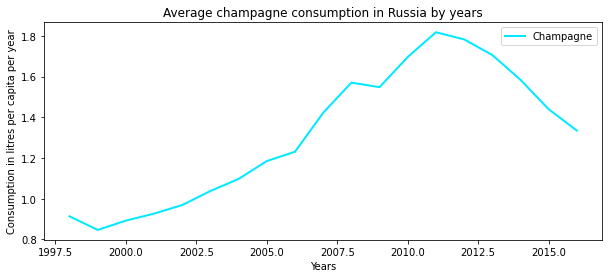

In [49]:
# Let's keep in the chart only data for сhampagne
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_champagne_mean, '#00eaff', linewidth=2, label='Сhampagne')

ax.set_title('Average сhampagne consumption in Russia by years')
ax.set_xlabel('Years')
ax.set_ylabel('Consumption in litres per capita per year')
ax.legend()
 
plt.show()

Champagne in Russia is less popular than vodka, beer or wine. Champagne consumption several times less than drinks we observed earlier.

However during the analysis period champagne consumption in Russia increased from 0,9 liters per capita in 1998 to 1,3 liters in 2016. The peak was during the same period as a beer peak. In 2011-2012 years consumption was 1,8 liters per capita.

Let's check that the difference is statistically significant.

In [50]:
data1 = np_champagne_mean[:9]
data2 = np_champagne_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 0.0
p-value = 0.00013985013509334326


p-value = 0,01% and Mann-Whitney U-test = 0. Based on that result, we can't see considerable variation between the first and the second part of the reporting period in champagne consumption.

##**Brandy consumption in Russia by years**

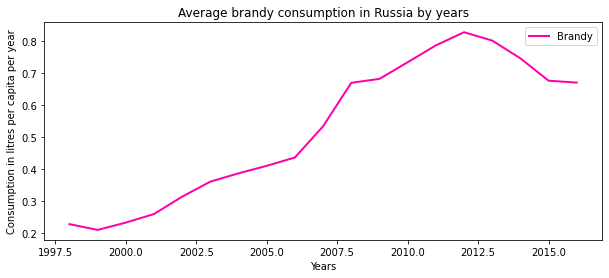

In [51]:
# Let's keep in the chart only data for brandy
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np_years, np_brandy_mean, '#ff00a8', linewidth=2, label='Brandy')

ax.set_title('Average brandy consumption in Russia by years')
ax.set_xlabel('Years')
ax.set_ylabel('Consumption in litres per capita per year')
ax.legend()
 
plt.show()

Brandy consumption, the same as other drinks reviewed earlier, increased.


In 1998 the brandy consumption was 0,23 liters per capita and in 2016 - 0,67 liters. The peak number occur for 2012 when the consumption reached 0,83 liters per capita per year.


Notwithstanding, the brandy consumption is closer to champagne numbers and much lower than wine, vodka, and beer.

In [52]:
data1 = np_brandy_mean[:9]
data2 = np_brandy_mean[9:]
stat, p = mannwhitneyu(data1, data2)
print("Mann-Whitney U =", stat)
print("p-value =", p) 

Mann-Whitney U = 0.0
p-value = 0.00013985013509334326


The Mann-Whitney U-test shows that there is no statistical difference between samples. P-value < 0,05 and we can consider the result as statistically reliable.

## **Resume of alcohol consumption in Russia in a total**
1. The myth that in Russia drinks only vodka is not true. Russian people drink vodka but the consumption become less during the years.
2. Beer is a leader of consumption and the amount of liters per capita is 3-6 times more than for other drinks.
3. With the country's welfare, wine consumption increases and vodka decreases. In doing so, champagne and brandy didn't show significant changes.
4. At the beginning of 2000, there has been a sharp in beer consumption per capita.The maximum occurs for 2007-2012 and since 2012 we can observe the recession. The consumption 3 times increased compared to 1998. Hypothesis. The sharp increase in consumption was due to technological development and the opening of private breweries. Also, important factors are the trend for craft beer and the opening of a huge amount of draft beer stores. Customers got more options to choose and beer became better quality. The same period of time improved the well-being of the population and people just got more free funds for the nonpriority needs. Another factor is the cultural aspect and moving from home dinners to bars and restaurants. Anyway, to prove these hypotheses needs more specific data.
5. On the charts is obvious the inverse relationship between vodka and other drinks consumption. Only vodka consumption decrease meanwhile other drinks increase. In 2016 consumption of vodka and wine was very close to each other: 5,9 liters of wine and 6,6 liters of vodka per capita.

# Fill out missing data with regional averages

Let's find the average number for each region by the type of drink.

In [53]:
df_region_mean = df_filter.groupby('region').mean()

for drink in ['wine', 'beer', 'vodka', 'champagne', 'brandy']:
      df_filter.loc[df_filter[drink].isna(), drink] = df_filter.loc[df_filter[drink].isna(), 'region'].apply(lambda reg: df_region_mean.loc[reg, drink])

df_filter.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


# Top regions with the maximum alcohol consumption

##**Top 5 regions of wine consumption by capita**

In [54]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Stavropol Krai,8.800000,5.900000,6.400000,5.900000,6.000000,6.100000,6.200000,6.800000,7.300000,6.800000,6.800000,6.400000,5.400000,5.970000,5.500000,4.500000,4.800000,3.900000,3.800000
Krasnodar Krai,8.500000,6.800000,7.000000,6.600000,7.900000,8.700000,8.800000,8.900000,8.300000,8.200000,8.700000,7.800000,6.700000,6.470000,5.700000,5.100000,5.600000,5.600000,5.300000
Moscow,6.800000,6.600000,6.300000,5.000000,4.800000,6.200000,6.100000,6.400000,5.900000,7.300000,8.400000,9.400000,10.100000,9.850000,9.700000,8.800000,8.500000,7.500000,6.600000
Kamchatka Krai,6.400000,6.500000,7.100000,7.400000,7.300000,7.400000,7.500000,8.600000,8.000000,7.800000,7.200000,7.600000,7.700000,7.590000,7.500000,6.700000,6.400000,7.000000,6.600000
Magadan Oblast,6.200000,4.800000,4.300000,4.700000,4.000000,4.800000,5.900000,6.700000,6.600000,7.300000,8.100000,8.800000,7.900000,8.170000,8.000000,6.800000,7.700000,8.200000,7.600000


The list of the top cities in 1998
1. Stavropol Krai - 8,8 liters per capita
2. Krasnodar Krai - 8,5 liters
3. Moscow - 6,8 liters
4. Kamchatka Krai - 6,4 liters
5. Magadan Oblas - 6,2 liters

But you could notice in the table that the top of the cities changed during the reporting period.

In [55]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Nenets Autonomous Okrug,4.300000,4.600000,5.500000,7.000000,8.100000,9.200000,7.000000,7.600000,8.600000,10.100000,10.700000,11.300000,12.000000,10.530000,9.900000,8.400000,11.400000,12.800000,11.700000
Republic of Karelia,3.200000,2.400000,2.800000,5.100000,9.300000,13.500000,16.900000,15.000000,14.700000,11.900000,14.300000,13.600000,12.900000,11.980000,10.600000,10.800000,12.300000,11.700000,11.500000
Novgorod Oblast,4.100000,4.900000,4.600000,4.600000,5.000000,5.500000,5.900000,6.100000,6.400000,12.100000,14.500000,14.800000,14.800000,13.710000,13.100000,11.300000,12.000000,10.500000,10.600000
Pskov Oblast,1.800000,6.100000,7.100000,9.600000,10.300000,13.500000,17.500000,12.800000,11.800000,10.200000,9.500000,10.300000,13.600000,12.750000,9.500000,7.300000,12.100000,9.700000,10.400000
Yaroslavl Oblast,3.500000,3.600000,3.500000,4.300000,4.500000,3.800000,3.900000,5.500000,5.700000,9.700000,10.400000,10.000000,11.300000,10.270000,9.700000,7.600000,9.900000,9.300000,10.200000


Top 5 cities with the highest wine consumption in 2016 below:
1. Nenets Autonomous Okrug - 11,7 liters
2. Republic of Karelia - 11,5 liters
3. Novgorod Oblast - 10,6 liters
4. Pskov Oblast - 10,4 liters
5. Yaroslavl Oblast - 10,2 liters

In 1998 first positions took south cities were the wine production is traditional, but by 2016 the geography of consumption is shifting north.


As an option, that the wine consumption on the noth regions related to the improvement of the welfare of the population in general. And another factor, supply to remote regions of the country improved. However, during the reporting period wine consumption in the south of Russia decreased nearly halved.

In [56]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chukotka Autonomous Okrug,0.300000,0.400000,1.000000,1.400000,1.900000,3.800000,3.400000,4.000000,5.500000,6.300000,8.400000,4.900000,5.500000,5.230000,5.100000,4.000000,9.600000,4.700000,3.900000
Primorsky Krai,0.600000,1.200000,1.800000,1.500000,1.600000,1.700000,2.800000,5.200000,4.600000,4.900000,5.300000,5.600000,5.500000,6.030000,6.700000,5.900000,6.700000,6.200000,6.800000
Zabaykalsky Krai,0.900000,1.100000,1.900000,3.500000,4.700000,5.900000,15.700000,16.300000,13.700000,6.700000,6.900000,6.500000,6.400000,6.520000,6.600000,6.400000,6.600000,6.600000,6.400000
Ulyanovsk Oblast,1.000000,1.100000,0.800000,1.100000,2.100000,4.100000,5.500000,5.200000,4.500000,5.300000,6.800000,6.400000,7.000000,7.410000,6.600000,5.300000,6.400000,7.600000,6.600000


Top 5 regions with the least wine consumption in 1998 was looking like this: 
1. Chechen Republic - 0 liters
2. Chukotka Autonomus Okrug - 0,3 liters
3. Primorsky Krai - 0,6 liters
4. Zabaykalsky Krai - 0,9 liters
5. Ulyanovsk Oblast - 1 liter per person per year

In the Far East in 1998 wine wasn't popular.

Let's see how has the image changed till 2016.

In [57]:
wine_region = pd.pivot_table(df_filter, values='wine', index='region', columns='year', aggfunc='sum')

wine_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['wine'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of Dagestan,4.800000,3.800000,3.800000,4.600000,2.700000,2.900000,2.800000,2.400000,2.900000,2.400000,3.100000,3.800000,3.300000,3.270000,1.600000,1.000000,0.400000,0.400000,0.100000
Republic of North Ossetia-Alania,1.400000,1.700000,2.600000,5.600000,1.000000,0.200000,2.300000,2.200000,2.500000,2.500000,1.900000,1.500000,1.700000,1.720000,1.400000,1.300000,0.600000,0.500000,0.500000
Kabardino-Balkar Republic,1.600000,1.800000,2.500000,2.700000,3.700000,4.400000,4.000000,3.300000,2.500000,2.900000,3.400000,3.200000,3.200000,2.660000,1.700000,0.800000,0.500000,0.600000,0.600000
Karachay-Cherkess Republic,1.700000,2.100000,2.200000,2.300000,2.700000,3.700000,4.200000,4.600000,3.000000,2.000000,1.900000,1.500000,1.400000,1.360000,1.300000,1.100000,1.200000,1.100000,0.900000


In 2016 the most non-drinking wine country remains Chechen Republic. Top 5 countries looks like this:
1. Chechen Republic - 0 литров
2. Republic of Dagestan - 0,1 литров
3. Republic of North Osetia-Alania - 0,5 литров
4. Kabardino-Balkar Republic - 0,6 литров
5. Karachay-Cherkess Republic - 0,9 литров

It's interesting to admit that in 1998 Dagestan was indicating the results on the whole close to the mean value in Russia and till 2016 wine consumption was gradually decreasing and almost came to a standstill. In Chechen Republic wine is still not drank.


##**Top 5 regions of beer consumption by capita**

In [58]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')

beer_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Omsk Oblast,42.100000,36.000000,41.500000,55.500000,84.200000,97.300000,26.600000,28.200000,30.400000,104.200000,126.300000,116.700000,118.800000,126.930000,125.200000,103.000000,79.700000,60.400000,53.200000
Republic of Khakassia,38.300000,48.700000,47.900000,53.600000,56.300000,61.200000,74.500000,73.600000,90.100000,73.100000,54.600000,58.500000,57.700000,68.000000,70.300000,68.600000,82.200000,84.300000,79.100000
Smolensk Oblast,35.600000,53.800000,55.300000,71.300000,96.200000,92.300000,84.500000,78.900000,66.200000,62.800000,60.700000,57.400000,54.200000,57.030000,58.300000,56.100000,55.500000,51.800000,48.000000
Ulyanovsk Oblast,34.800000,46.300000,46.100000,47.700000,44.800000,42.500000,45.300000,32.600000,49.500000,52.800000,41.100000,39.900000,40.000000,54.900000,54.600000,55.200000,47.600000,46.600000,46.900000
Magadan Oblast,33.800000,18.700000,24.600000,28.300000,33.000000,43.200000,39.400000,40.200000,42.400000,42.000000,34.200000,41.500000,55.500000,55.400000,59.900000,61.600000,63.500000,59.800000,56.500000


Top regions with the biggest beer consumption in 1998 looked like this:
1. Omsk Oblast - 42.2 liters
2. Republic of Khakassia - 38.3 liters
3. Smolensk Oblast - 35.6 liters
4. Ulyanovsk Oblast - 34.8 liters
5. Magadan Oblast - 33.8 liters

All that said it's interesting to notice uneven increase of beer consumption in particular regions from year to year.

For instance, even though Omsk Oblast took the first place for beer consumption in 1998, this value is below the average beer consumption of all the period. There is also a sufficient leap of beer consumption in this region in 2002-2003 and then as sharp recession in 2004-2006.

Data about Omsk Oblast:
* 1998 - 42.1 liter per person per year
* 1999 - 36 liters
* 2000 - 41.5 liters
* 2001 - 55.5 liters
* 2002 - 84.2 liters
* 2003 - 97.3 liters
* 2004 - 26.6 liters

Probably this difference happened because of different method of calculation, or because of external reason. 

In [59]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')
beer_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow Oblast,11.900000,15.800000,22.600000,23.700000,29.400000,29.600000,30.500000,32.300000,38.700000,67.400000,86.000000,100.600000,100.600000,108.640000,101.000000,99.000000,97.700000,94.900000,99.100000
Kamchatka Krai,25.500000,30.600000,32.700000,33.600000,35.300000,39.100000,49.200000,50.500000,69.100000,69.600000,73.400000,75.000000,75.600000,77.770000,76.000000,76.300000,76.000000,81.200000,85.400000
Republic of Khakassia,38.300000,48.700000,47.900000,53.600000,56.300000,61.200000,74.500000,73.600000,90.100000,73.100000,54.600000,58.500000,57.700000,68.000000,70.300000,68.600000,82.200000,84.300000,79.100000
Yamalo-Nenets Autonomous Okrug,23.800000,34.400000,36.900000,49.000000,77.000000,93.300000,94.500000,101.100000,106.600000,95.400000,93.400000,86.600000,87.400000,100.920000,99.900000,97.700000,86.200000,82.700000,75.800000
Khabarovsk Krai,24.800000,30.000000,31.900000,38.400000,31.800000,47.400000,53.400000,70.500000,85.700000,93.700000,99.600000,94.700000,101.400000,104.940000,98.200000,94.300000,90.900000,68.300000,73.700000


By 2016 top 5 regions by beer consumption per person looked like this:

1. Moscow Oblast - 99.1 liters
2. Kamchatka Krai - 85.4 liters
3. Republic of Khakassia - 79.1 liters
4. Yamalo-Nenets Autonomus Okrug - 75.8 liters
5. Khabarovsk Krai - 73.7 liters

Comparing to 1998 total number of beer consumption increased overall 3 times. Herewith top of the regions had changed. Among the consumers remained only Republic of Khakassia which has moved from the second to the third place in the chart. The other regions had changed.

Moscow is entering the top of regions by beer consumption only from 2007. Till that time the consumption metrics were lower than average across Russia.

In [60]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')

beer_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chukotka Autonomous Okrug,1.800000,2.300000,5.200000,11.000000,6.400000,12.300000,10.800000,9.100000,11.000000,12.700000,16.700000,9.800000,17.700000,16.910000,24.000000,27.000000,32.700000,31.500000,34.000000
Chechen Republic,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,4.900000,2.200000,1.200000
Republic of Dagestan,3.800000,1.600000,1.800000,3.300000,9.600000,9.700000,6.600000,10.400000,6.900000,5.900000,6.600000,6.300000,3.100000,2.740000,2.500000,2.100000,2.200000,2.100000,1.000000
Republic of Kalmykia,4.100000,5.200000,9.100000,13.900000,20.900000,24.400000,24.400000,25.100000,34.000000,29.300000,24.900000,26.800000,24.300000,17.900000,15.900000,13.600000,17.400000,19.600000,20.300000
Karachay-Cherkess Republic,5.400000,6.900000,7.400000,9.400000,13.200000,14.900000,19.600000,20.900000,22.100000,23.000000,27.800000,29.100000,28.400000,29.530000,28.700000,28.100000,28.100000,28.900000,25.300000


Top 5 regions with the lowest beer consumption rates in 1998 looked like this:
1. Chukotka Autnomus Okrug - 1.8 liters per person per year
2. Chechen Republic - 2.8 liters
3. Republic of Dagestan - 3.8 liters
4. Republic of Kalmykia - 4.1 liters
5. Karachay-Cherkess Republic - 5.4 liters

Comparing to the top of the regions with the lowesr rates of beer consumption, there also are Chechen Republic and Chukotka Autonomus Okrug. The other three regions are different.

Concurrently, in Chukotka Autonomus Okrug beer consumption was gradually rising whereas in Chechen Republic and Republic of Dagestan it was decreasing,

Let's see how has the top of the most less-drinking regions  changed with the time.


In [61]:
beer_region = pd.pivot_table(df_filter, values='beer', index='region', columns='year', aggfunc='sum')

beer_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['beer'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Republic of Dagestan,3.800000,1.600000,1.800000,3.300000,9.600000,9.700000,6.600000,10.400000,6.900000,5.900000,6.600000,6.300000,3.100000,2.740000,2.500000,2.100000,2.200000,2.100000,1.000000
Chechen Republic,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,2.766667,4.900000,2.200000,1.200000
Kabardino-Balkar Republic,9.900000,12.600000,17.300000,26.500000,31.500000,39.400000,43.700000,31.700000,38.100000,24.300000,25.800000,30.200000,26.100000,23.280000,20.400000,17.800000,17.100000,16.300000,14.500000
Republic of North Ossetia-Alania,23.300000,24.100000,19.900000,15.700000,14.900000,14.500000,15.800000,16.000000,17.500000,15.700000,12.300000,11.700000,14.300000,17.650000,21.000000,20.700000,19.800000,19.200000,17.300000
Republic of Kalmykia,4.100000,5.200000,9.100000,13.900000,20.900000,24.400000,24.400000,25.100000,34.000000,29.300000,24.900000,26.800000,24.300000,17.900000,15.900000,13.600000,17.400000,19.600000,20.300000


In 2016 Top of the regions with the lowest rates of beer consumption looks like this:
1. Republic of Dagestan - 1 litre
2. Chechen Republic - 1.2 liters
3. Kabardino-Balkar Republic - 14.5 liters
4. Republic of North Ossetia-Alania - 17.3 liters
5. Republic of Kalmykia - 20.3 liters

Top of the most sober regions concerning beer and wine in 2016 are practically the same. 4 out of 5 regions are matching. Karachaevo-Cherkess Republic is making it to the top of the regions of the lowest rates of beer consumption, and what concerns beer Republic of Kalmykia gets into the top. Other than than that the top is the same.

##**Top 5 regions of vodka consumption by capita**


In [62]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')

vodka_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Kamchatka Krai,25.100000,26.400000,26.600000,26.700000,25.900000,25.100000,22.200000,22.800000,20.400000,18.600000,18.200000,17.500000,16.900000,16.830000,15.400000,15.100000,13.000000,11.400000,10.400000
Magadan Oblast,23.100000,23.200000,23.900000,23.600000,18.900000,18.400000,16.800000,16.500000,16.300000,16.300000,17.100000,20.800000,18.100000,17.530000,24.300000,17.800000,16.500000,14.100000,12.700000
Yaroslavl Oblast,21.100000,21.100000,18.300000,18.600000,20.300000,18.600000,18.900000,14.500000,14.700000,15.100000,13.900000,13.600000,12.200000,11.840000,12.700000,11.100000,9.800000,8.700000,8.900000
Komi Republic,21.100000,25.900000,27.400000,28.500000,28.400000,29.700000,28.100000,26.700000,18.600000,15.600000,15.800000,16.700000,17.100000,17.830000,18.900000,16.300000,14.300000,13.000000,12.500000
Vologda Oblast,19.300000,17.400000,19.200000,23.000000,22.200000,24.600000,26.700000,21.900000,17.500000,16.200000,17.500000,15.200000,12.900000,15.440000,14.900000,12.900000,11.100000,9.300000,9.900000


In 1998, the most vodka-drinking region was Kamchatka Krai - 25 liters per person per year. Full top 5 list by vodka consumption in 1998:

1. Kamchatka Krai - 25.1 liters
2. Magadan Oblast - 23.1 liters
3. Yaroslavl Oblast - 21.1 liters
4. Komi Republic - 21.1 liters
5. Vologda oblast - 19.3 liters

It is noteworthy that only the most eastern regions made it to the top of the most vodka-drinking regions .

In 1998 Magadan Oblast was in the top 5 regions by beer, wine and vodka consumption per person.

In [63]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')
vodka_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Sakhalin Oblast,16.300000,21.000000,18.800000,20.300000,24.500000,23.200000,20.300000,19.100000,17.100000,17.800000,19.200000,19.200000,18.800000,18.510000,17.100000,15.000000,13.400000,13.000000,12.800000
Magadan Oblast,23.100000,23.200000,23.900000,23.600000,18.900000,18.400000,16.800000,16.500000,16.300000,16.300000,17.100000,20.800000,18.100000,17.530000,24.300000,17.800000,16.500000,14.100000,12.700000
Komi Republic,21.100000,25.900000,27.400000,28.500000,28.400000,29.700000,28.100000,26.700000,18.600000,15.600000,15.800000,16.700000,17.100000,17.830000,18.900000,16.300000,14.300000,13.000000,12.500000
Arkhangelsk Oblast,11.700000,14.900000,19.200000,23.500000,29.500000,31.900000,18.500000,17.600000,16.900000,15.600000,16.600000,15.900000,16.200000,16.640000,14.400000,14.400000,12.800000,11.800000,12.200000
Murmansk Oblast,16.600000,17.800000,18.800000,19.700000,20.900000,21.300000,21.700000,21.900000,19.300000,18.900000,17.700000,15.300000,12.700000,12.600000,13.100000,13.200000,11.300000,12.200000,12.200000


All in all, vodka consumption in the accounting period has sufficiently decreased and in 2016 ceiling values were lower than ceiling values in 1998. Concurrently, the top of the regions has also changed.
Top 5 regions by vodka consumption in 2016:
1. Sakhalin oblast - 12.8 liters
2. Magadan Oblast - 12.7 liters
3. Komi Republic - 12.5 liters
4. Murmansk Oblast - 12.2 liters
5. Republic of Kareliya - 12.2 liters

In [64]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')

vodka_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of Dagestan,2.000000,1.000000,1.000000,1.800000,4.900000,8.700000,9.500000,10.800000,11.700000,12.200000,12.900000,13.200000,10.200000,7.880000,8.000000,4.800000,2.900000,1.900000,2.200000
Republic of Adygea,3.400000,4.300000,5.400000,7.800000,7.900000,8.000000,8.600000,10.400000,8.100000,6.800000,6.400000,7.400000,6.600000,6.900000,5.600000,4.700000,4.100000,3.500000,3.600000
Republic of Crimea,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,4.266667,3.900000,3.800000,5.100000
Kursk Oblast,4.400000,4.800000,6.100000,7.400000,6.700000,7.500000,7.200000,7.900000,7.200000,8.000000,7.700000,8.400000,8.400000,7.730000,7.700000,7.600000,4.300000,3.800000,4.000000


Let's take a look on a top regions with the least vodka consumption in 1998:

1. Republic of Dagestan - 2 liters
2. Republic of Adygea - 3.4 liters
3. Republic of Crimea - 4.2 liters
4. Republic of Crimea - 4.4. liters
5. Chukotka Autonomus Okrug - 4.6 liters

Republic of Dagestan and Chukotka Autonomus Okrug are upholding the image of the most sober regions of Russia.


In [65]:
vodka_region = pd.pivot_table(df_filter, values='vodka', index='region', columns='year', aggfunc='sum')

vodka_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['vodka'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of North Ossetia-Alania,10.600000,11.000000,9.800000,8.900000,8.500000,7.600000,5.300000,3.400000,3.800000,3.900000,3.400000,3.000000,3.200000,3.350000,2.800000,2.200000,1.300000,0.600000,0.400000
Kabardino-Balkar Republic,6.500000,8.200000,10.500000,12.400000,13.900000,12.800000,12.300000,10.400000,6.600000,5.100000,5.200000,3.700000,3.500000,3.080000,2.300000,1.600000,0.600000,0.500000,0.500000
Karachay-Cherkess Republic,8.600000,10.900000,12.900000,13.400000,14.300000,14.900000,14.900000,5.300000,5.600000,5.100000,3.700000,2.800000,2.300000,2.170000,1.800000,1.200000,0.900000,0.800000,0.700000
Republic of Dagestan,2.000000,1.000000,1.000000,1.800000,4.900000,8.700000,9.500000,10.800000,11.700000,12.200000,12.900000,13.200000,10.200000,7.880000,8.000000,4.800000,2.900000,1.900000,2.200000


By 2016 top of the regions with the lowest rates of vodka consumption has changed in this way:
1. Republic of Northern Ossetia-Alania - 0.4 liters
2. Kabardino-Balkar Republic - 0.5 liters
3. Karachay-Cherkess Republic - 0.7 liters
4. Republic of Dagestan - 2.2 liters
5. Stavropol Kray - 2.3 liters

Southern regions of Russia are different in low vodka consumption rates. There is obvious positive momentum in decreasing of vodka consumption in Russia from 1998 till 2016.

During accounting period in the region with the highest consumption rates the consumption decreast from 25.1 liters to 12.8 liters per person per year. Minimal consumption has also decreased from 2 liters to 0.4 liters per person per year.



## **TOP 5 regions by champagne consumption per person**

In [66]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')

champagne_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['champagne'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,3.500000,3.600000,3.900000,4.200000,4.000000,4.100000,3.800000,3.700000,4.200000,4.800000,5.000000,4.800000,4.900000,5.140000,5.000000,5.100000,5.100000,4.500000,4.000000
Magadan Oblast,2.100000,1.700000,1.800000,1.400000,1.400000,1.800000,1.900000,2.000000,2.500000,3.200000,3.600000,3.800000,4.000000,4.060000,4.900000,4.300000,4.300000,3.900000,3.100000
Sevastopol,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,1.966667,2.100000,2.000000,1.800000
Komi Republic,1.900000,2.500000,1.900000,0.800000,0.900000,0.800000,1.100000,1.200000,1.300000,1.800000,1.800000,1.900000,2.200000,2.250000,2.200000,2.400000,2.000000,1.700000,1.600000
Samara Oblast,1.800000,1.300000,1.500000,1.000000,1.200000,1.100000,1.100000,0.900000,1.300000,1.400000,1.700000,1.500000,1.900000,2.380000,1.900000,1.900000,1.700000,1.300000,1.200000


Champagne consumption in Russia in 1998 was sufficiently lower comparing to the other drinks.

Top 5 regions with the highest champane consumption rates in 1998:

1. Moscow Oblast - 3.5 liters
2. Magadan Oblast - 2.1 liters
3. Sevastopol Oblast - 1.9 liters
4. Komi Republic - 1.9 liters
5. Samara Oblast - 1.8 литров

It seems to be logical Moscow's being on the first place of the chart as it is the region with the highest standart of living. On the second place there is Magadan that is the most drinking region of Russia, concerning champagne and other drinks too.

With the flow of time percentage of champagne consumption was changing but the changes in numerical values weren't sufficial. The averages during the accounting period were changing from 0,9 liters to 1,3 liters in 2016 with the peak in 2011-2012 - 1,8 liters per person per year.


In [67]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')
champagne_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['champagne'].mean() else "background-color: white")

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Moscow,3.500000,3.600000,3.900000,4.200000,4.000000,4.100000,3.800000,3.700000,4.200000,4.800000,5.000000,4.800000,4.900000,5.140000,5.000000,5.100000,5.100000,4.500000,4.000000
Kamchatka Krai,0.800000,0.900000,0.800000,0.900000,1.200000,1.800000,2.000000,2.100000,2.900000,3.300000,3.700000,3.900000,4.100000,4.200000,4.300000,4.100000,4.000000,3.700000,3.300000
Sakhalin Oblast,0.700000,0.400000,0.500000,0.900000,1.600000,1.400000,1.500000,2.200000,1.900000,2.100000,3.000000,3.500000,3.800000,3.890000,3.800000,3.800000,3.800000,3.900000,3.300000
Magadan Oblast,2.100000,1.700000,1.800000,1.400000,1.400000,1.800000,1.900000,2.000000,2.500000,3.200000,3.600000,3.800000,4.000000,4.060000,4.900000,4.300000,4.300000,3.900000,3.100000
Khabarovsk Krai,1.400000,1.100000,0.700000,0.500000,0.700000,0.700000,0.900000,1.000000,1.400000,2.100000,2.900000,2.900000,3.100000,3.080000,3.600000,3.100000,3.000000,2.800000,2.600000


Top of the regions by champagne consumption in 2016

1. Moscow Oblast - 4 liters
2. Kamchatka Krai - 3.3 liters
3. Sakhalin Oblast - 3.3 liters 
4. Magadan Oblast - 3.1 liters
5. Nenets Аutonomous Okrug- 2.6 liters

Even thought there were some changers in the top of the regions during the accounting period, Moscow kept the first place and Magadan is still in the top of the regions with the highest champagne consumption rates.

In the numerical values the difference between 1998 and 2016 is the least sufficient, comparing to another drinks.


In [68]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')
champagne_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['champagne'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Karachay-Cherkess Republic,0.100000,0.100000,0.200000,0.200000,0.200000,0.200000,0.300000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.470000,0.500000,0.400000,0.400000,0.300000,0.200000
Ivanovo Oblast,0.100000,0.100000,0.200000,0.300000,0.600000,0.600000,0.700000,1.000000,1.000000,1.300000,1.300000,1.300000,1.500000,1.570000,1.700000,1.700000,1.000000,0.900000,1.100000
Penza Oblast,0.200000,0.400000,0.300000,0.400000,0.400000,0.600000,0.600000,1.000000,0.800000,0.900000,1.000000,1.100000,1.200000,1.220000,1.000000,1.000000,0.900000,0.700000,0.600000
Zabaykalsky Krai,0.200000,0.200000,0.300000,0.400000,0.500000,0.600000,3.000000,3.000000,3.100000,0.800000,0.900000,1.000000,1.000000,1.070000,1.100000,1.100000,1.100000,0.900000,0.900000


Top 5 list of the regions with the least champagne consumption in 1998.
1. Karachay-Cherkess Republic - 0.1 liters
2. Ivanovo Oblast - 0.1 liters
3. Penza Oblast - 0.2 liters
4. Zabaykalsky Krai - 0.2 liters
5. Republic of Adygea - 0.3 liters

Champagne consumption is very low. Probably, in these particular regions this drink is being drank only for special occasions and holidays.


In [69]:
champagne_region = pd.pivot_table(df_filter, values='champagne', index='region', columns='year', aggfunc='sum')

champagne_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['champagne'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Karachay-Cherkess Republic,0.100000,0.100000,0.200000,0.200000,0.200000,0.200000,0.300000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.470000,0.500000,0.400000,0.400000,0.300000,0.200000
Kabardino-Balkar Republic,0.300000,0.400000,0.600000,0.400000,0.700000,0.800000,0.800000,1.100000,1.200000,1.000000,0.600000,0.400000,0.400000,0.550000,0.500000,0.300000,0.300000,0.300000,0.200000
Republic of Dagestan,0.500000,0.200000,0.200000,0.400000,0.600000,1.200000,1.500000,1.500000,1.300000,1.200000,0.700000,0.700000,0.400000,0.380000,0.400000,0.300000,0.200000,0.300000,0.200000
Republic of Kalmykia,0.300000,0.600000,0.900000,1.300000,1.500000,1.400000,1.400000,1.600000,1.600000,0.600000,0.400000,0.300000,0.300000,0.330000,0.400000,0.300000,0.300000,0.300000,0.300000


In 2016 top 5 of the regions with the lowest champagne consumption rates started to look like this:

1. Kabardino-Balkar Republic - 0.2 liters
2. Republic of Dagestan - 0.2 liters
3. Karachay-Cherkess Republic - 0.2 liters
4. Republic of Kalmykia - 0.3 liters
5. Republic of Northern Ossetia - 0.4 liters

For 2016, South Of Russia remains the region with the least champagne consuption.


##**TOP 5 regions by brandy consumption per person**


In [70]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')

brandy_region.sort_values(by=1998, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['brandy'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Sevastopol,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.100000,1.300000,0.900000,1.100000
Republic of Crimea,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,1.100000,0.900000,0.700000
Moscow,0.700000,0.700000,0.600000,0.700000,0.900000,0.900000,1.000000,1.000000,1.200000,1.500000,1.600000,1.800000,1.800000,1.800000,1.700000,1.700000,1.700000,1.500000,1.100000
Omsk Oblast,0.600000,0.500000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.200000,0.300000,0.300000,0.400000,0.440000,0.500000,0.500000,0.500000,0.400000,0.500000
Murmansk Oblast,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.700000,0.800000,0.900000,1.300000,1.400000,1.500000,1.520000,1.700000,1.700000,1.700000,1.900000,1.900000


Like champagne consumption, brandy consumption rates in Russia are on a low level.

Top 5 regions by brandy consumption in 1998 looked like this:

1. Sevastopol - 1.1. liters
2. Republic of Crimea - 0.9 liters
3. Moscow Oblast - 0.7 liters
4. Omsk Oblast - 0.6 liters
5. Murmansk Oblast - 0.6 liters

The highest brandy consumption rates of brandy consumption in 1998 belong to Republic of Crimea and it is explaned by production of this drink im this region. Right after this region on the chart is Moscow, as a region with the high standart of living where the inhabitants can afford buying more expensive drinks.


In [71]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')
brandy_region.sort_values(by=2016, ascending=False).head(5).style.applymap(lambda x: "background-color: #e65a71" if x>df_region_mean['brandy'].mean() else "background-color: white")

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Murmansk Oblast,0.600000,0.600000,0.600000,0.600000,0.600000,0.700000,0.700000,0.700000,0.800000,0.900000,1.300000,1.400000,1.500000,1.520000,1.700000,1.700000,1.700000,1.900000,1.900000
Yamalo-Nenets Autonomous Okrug,0.300000,0.300000,0.300000,0.500000,0.600000,0.500000,0.500000,0.500000,0.400000,1.100000,1.100000,1.300000,1.300000,1.780000,1.800000,1.700000,1.500000,1.300000,1.300000
Moscow Oblast,0.200000,0.300000,0.300000,0.300000,0.400000,0.400000,0.800000,1.100000,1.300000,1.400000,1.600000,1.400000,1.400000,1.310000,1.500000,1.500000,1.300000,1.200000,1.300000
Khanty–Mansi Autonomous Okrug – Yugra,0.300000,0.300000,0.300000,0.500000,0.600000,0.500000,0.500000,0.500000,0.400000,1.100000,1.100000,1.300000,1.300000,1.660000,1.600000,1.600000,1.400000,1.300000,1.300000
Kamchatka Krai,0.400000,0.400000,0.400000,0.400000,0.500000,1.200000,1.100000,1.400000,1.200000,1.500000,1.700000,1.800000,1.800000,1.760000,1.800000,1.800000,1.700000,1.500000,1.300000


By 2016 top of the regions with the highest brandy consumption looked like this:
1. Murmansk Oblast - 1.9 liters
2. Yamalo-Nenets Autonomous Okrug - 1.3 liters
3. Moscow Oblast - 1.3 liters
4. Khanty-Mansi Autonomous Okrug- Yugra - 1.3 liters
5. Kamchatka Krai - 1.3 liters

During the accounting period, Murmansk Oblast on the North of Russia got on the first place of the top. This region has lifted from the fifth to the first place during 1998-2016. The other regions in the top 5 has shared a second place. There is Moscow Oblast that remained in the top, the other another 3 regions had changed with the flow of time.


In [72]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')
brandy_region.sort_values(by=1998, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['brandy'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Chuvash Republic,0.020000,0.020000,0.100000,0.100000,0.200000,0.200000,0.200000,0.200000,0.200000,0.400000,0.500000,0.500000,0.500000,0.620000,0.600000,0.500000,0.500000,0.400000,0.400000
Pskov Oblast,0.040000,0.040000,0.100000,0.100000,0.100000,0.100000,0.200000,0.200000,0.200000,0.400000,0.700000,0.700000,0.900000,0.880000,0.900000,0.600000,0.700000,0.700000,0.800000
Karachay-Cherkess Republic,0.040000,0.040000,0.100000,0.100000,0.100000,0.200000,0.300000,0.400000,0.400000,0.400000,0.500000,0.500000,0.500000,0.460000,0.400000,0.300000,0.200000,0.200000,0.100000
Ivanovo Oblast,0.040000,0.040000,0.100000,0.100000,0.200000,0.200000,0.400000,0.400000,0.400000,0.400000,0.400000,0.500000,0.500000,0.570000,0.600000,0.600000,0.600000,0.500000,0.500000


Top of the regions with the least brandy consumption in 1998.

1. Chechen republic - 0 liters
2. Chuvash Republic - 0.02 liters
3. Pskov Oblast - 0.04 liters
4. Karachay-Cherkess Republic - 0.04 liters
5. Ivanovo Oblast - 0.04 liters

Chechen Republic is upholding the image of one of the most sober regions of Russia.


In [73]:
brandy_region = pd.pivot_table(df_filter, values='brandy', index='region', columns='year', aggfunc='sum')

brandy_region.sort_values(by=2016, ascending=True).head(5).style.applymap(lambda x: "background-color: #97ca9b" if x<df_region_mean['brandy'].mean() else "background-color: white")   

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Republic of North Ossetia-Alania,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.300000,0.260000,0.300000,0.200000,0.100000,0.100000,0.100000
Karachay-Cherkess Republic,0.040000,0.040000,0.100000,0.100000,0.100000,0.200000,0.300000,0.400000,0.400000,0.400000,0.500000,0.500000,0.500000,0.460000,0.400000,0.300000,0.200000,0.200000,0.100000
Kabardino-Balkar Republic,0.300000,0.300000,0.400000,0.600000,0.700000,0.700000,0.700000,0.600000,0.500000,0.400000,0.400000,0.400000,0.400000,0.390000,0.300000,0.200000,0.100000,0.100000,0.100000
Tuva Republic,0.100000,0.400000,0.400000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.200000,0.300000,0.300000,0.400000,0.370000,0.400000,0.400000,0.300000,0.200000,0.200000


By 2016 top of the regions with the lowest brandy consumption rates has changed.

1. Chechen Republic - 0 liters 
2. Republic of North Ossetia-Alania - 0.1 liters
3. Karachay-Cherkess Republic - 0.1 liters
4. Kabardino-Balkar Republic - 0.1 liters
5. Tuva Republic - 0.2 liters

Chechen Republic is still on the first place during the accounting period showing zero consumption of brandy. At the meantime, Southern regions of the country are entering the top



#**Regions with the highest consumption rates of alcohol in Russia**


1. Moscow makes it to be in the top of the most drinking regions of Russia. Moscow region has got into the top of wine consumption in 1998 (6.8 liters). It has also taken first place by beer consumption in 2017 with a value of 99.1 liters per person per year. It has consistently saved it's first place by champagne consumption during all the accounting period and in 2016 consumption of this drink has made up 4 liters per person per year. Besides, Moscow oblast is consistently into the top of the regions by brandy consumption rates, and in 2016 the number has made up 1.3 liters.


2. Kamchatka Krai is present in the top list of the most drinking regions as regards most categories of drinks. In 1998 this region took 4th place by wine consumption (6.4 liters) and 1st place by vodka consumption (25.1 liters). In 2016 Kamchatka made it to be on the 2nd place by beer consumption (3.3 liters) and 5th place by brandy consumption - 1.3 liters.


3. Frequently we could see Magadan Oblast in top of the regions.In 1998 it has taken 5th place by wine consumption (6.2 liters), 5th place by beer consumption (33.8 liters), 2nd place by vodka consumption (23.1 liters) and 2nd place by champagne consumption (2.1 liters). By 2016 Magadan is still among the leaders and takes 2nd place by vodka consumption (12.7 liters) and 4th place by champagne consumption (3.1 liters). Thus Magadan is a leading region in Russia by alcohol consumption.


4. We need to admut Nenets Autonomous Okrug that has taken 1st place by wine consumption in 2016 (11.7 liters) and 5th place by champagne consumption (2.6 liters)


5. In Republic of Khakassia drinking beer is more preffered. This region made it to the 2nd place of the top by beer consumption in 1998 with the value of 38.3 liters and 3rd place in 2016 with value of 79.1 liters. 


6. Vodka is more preferred on the North-West of Russia. Komi Republic (12.5 liters), Murmansk Oblast (12.2 liters) and Republic of Kareliya (12.2 liters) are among the regions with the highest vodka consumption rates in 2016. In 2016 Murmansk Oblast has also taken 1st place by brandy consumption (1.9 liters).


7. Sakhalin Oblast has taken the first place by vodka consumption in 2016  with the value of 12.8 liters.




#**Regions of Russia with the least alcohol consumption**


1. Republic of Northern Ossetia, Kabardino-Balkar Republic, Republic of Dagestan and Chechen Republic are the regions with the lowest alcohol consumption rates in Russia.

2. Wine and brandy aren't drank in Chechen Republic at all. The values of consumptions of these drinks in this region are 0 liters both in 1998 and in 2016. At that, Chechen Republic has been steadily taking the 2nd place by the least beer consumption with value of 2.8 liters per year in 1998 and with the value of 1.2 liters per year in 2016.

3. Dagestan has taken 3rd place by vodka consumption in 1998 (3.8 liters) amd 1st place by vodka consumption (2 liters). By 2016, people in this region have started to drink less and the region has taken 2nd place by wine drinking (0.1 liters), 1st place y beer consumption (1 liter), 4th place by vodka consumption (2.2 liters) and 2nd place by champagne consumptio (0.2 liters). Thus, we can call Republic of Dagestan the least drinking region of Russia.

4. People of Chukotka hava also drunk few alcohol. In 1998 this region has taken 2nd place by wine consumption (0.3 liters), 1st place by beer consumption (1.8 liters) and 5th place by vodka consumption (4.6 liters). But by 2016 alcohol consumption comparing to the other parts of the country has raised and Chukotka has left the top of the regions with the lowest alcohol consumption rates.

5. A special place in the top of the regions with the least alcohol consumption is taken by Northern Ossetia, which hasn't make it to the top in 1998 but where the alcohol consuption has decreased by 2016. In 2016 Northern Ossetia has taken the 3rd place by wine consumption (0.5 liters), 4th place by beer drinking (17.3 liters), 1st place by vodka consumption (0.4 liters), 5th place by champagne consumption (0.4 liters) and 2nd place by brandy consumption (0.1 liters).

6. A similar image can be seen in Kabardino-Balkar Republic which has made it to the top of the regions with the lowest alcohol consumption rates by 2016 by taking 4th place by wine drinking (0.6 liters), 3rd place by beer drinking (14.5 liters), 2nd place by vodka consumption (0.5 liters), 1st place by champaghne consumption (0.2 liters) amnd 4th place by brandy consumption (0.1 liters)

7. Such Southern regions of the country as Karachay-Cherkess Republic, Kalmykia, Adygeia and Stavropol Kray are also in the top of the regions with thew lowest alcohol consumption rates.
